# Tutorial about statistical methods
The following contains a sequence of simple exercises, designed to get familiar with using Minuit for maximum likelihood fits and emcee to determine parameters by MCMC. Commands are generally commented, i.e. in order to activate them, simply uncomment them. A few functions are still to be defined... which is part of the exercise. Have fun!

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Generate a dataset to be fitted 

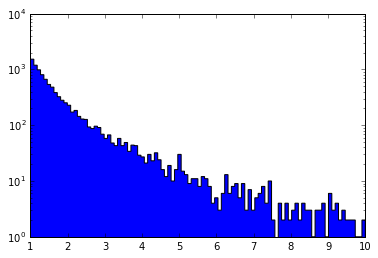

In [16]:
np.random.seed(42)
y = np.random.random(10000)
x = 1./np.sqrt(y)
plt.hist(x, bins=100, range=(1,10), histtype='stepfilled',color='blue')
plt.yscale('log')

## Maximum likelihood fit of a simple power law
First define the negative-log likelihood function for a density proportional to x**(-a) the range 1 < x < infinity

In [3]:
def nllp(a)
# here define the function 
    return 1.

SyntaxError: invalid syntax (<ipython-input-3-0295ef8a34b5>, line 1)

Then minimize it using iminuit

In [4]:
import iminuit

In [5]:
# minp = iminuit.Minuit(nllp,a= ?,error_a=?, errordef=?)

In [6]:
# minp.migrad()

## Error analysis
First determine the parabolic errors using hesse() and then do a parameter scan using minos() to determine the 68% confidence level errors.

In [7]:
# minp.hesse()

In [8]:
# minp.minos()
# minp.draw_profile('a')

## Use of an un-normalised PDF 
The above example shall be modified such that the normalisation of the likelihood function, which so far was determined analytically, now is determined numerically in the fit. This is the more realistic case, since in many case no (simple) analytical normalisation exists. As a first step, this requires to load the integration package.   

In [9]:
from scipy.integrate import quad

In [10]:
def pdfpn(x, a):
    return x**(-a)
def pdfpn_norm(a):
# here insert the calculation of the normalisation as a function of a 
    return 1.
def nllpn(a):
# calculate and return the proper negative-log likelihood function
    return 1.

Then do the same minimization steps as before.

In [11]:
# minpn = iminuit.Minuit(nllpn, a=?, error_a=?, errordef=?)

In [12]:
# minpn.migrad()

## Extend the fit model by an exponential cutoff
The exponential cutoff is implemented by exp(-b*b*x), i.e. exponential growth is not allowed for real valued parameters b. The implications of this ansatz shall be discussed when looking at the solution. After that, the example can be modified to use exp(-b*x). 

Here the likelihood function has no (simple) analytical normalisation anymore, i.e. we directly do the numerical approach.

In [13]:
def pdfcn(x, a, b):
    return x**(-a)*np.exp(-b*b*x)
def pdfcn_norm(a, b):
# determine the normalization    
    return 1.
def nllcn(a, b):
# calculate an return the negative-log likelihood function
    return 1.

As before, use Minuit for minimisation and error analysis, but now in two dimensions. Study parabolic errors and minos errors, the latter both for the single variables and for both together.

In [17]:
# mincn = iminuit.Minuit(nllcn, a=?, b=?, error_a=?, error_b=?, errordef=?)

In [5]:
# mincn.migrad()

In [6]:
# mincn.hesse()

In [7]:
# mincn.minos()

In [8]:
# mincn.draw_profile('a')

In [9]:
# mincn.draw_profile('b')

In [10]:
# mincn.draw_contour('a','b')

## Do the same analysis by MCMC

In [25]:
import emcee

emcee requires as input the log-likelihood of the posterior in the parameters a and b. In the following it is composed of the log-of the prior and the log-likelihood of the data. Initially use a simple uniform prior in a and b with the constraint b>0. Afterwards one can play with the prior to see how strongly it affects the result.  

In [11]:
# Define the posterior.
# for clarity the prior and likelihood are separated
# emcee requires log-posterior

def log_prior(theta):
    a, b = theta
    if b < 0:
        return -np.inf  # log(0)
    else:
        return  0.

def log_likelihood(theta, x):
    a, b = theta
    return np.sum(-a*np.log(x) - b*b*x)

def log_posterior(theta, x):
    a , b = theta
# construct and the log of the posterior     
    return 1.

Here we'll set up the computation. emcee combines multiple "walkers", each of which is its own MCMC chain. The number of trace results will be nwalkers * nsteps

In [68]:
ndim     = 2     # number of parameters in the model
nwalkers = 50    # number of MCMC walkers
nburn    = 100   # "burn-in" period to let chains stabilize
nsteps   = 1000  # number of MCMC steps to take

# random starting point
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))


run the MCMC (and time it using IPython's %time magic

In [ ]:
#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x])
#%time sampler.run_mcmc(starting_guesses, nsteps)
#print("done")

sampler.chain is of shape (nwalkers, nsteps, ndim). Before analysis throw-out the burn-in points and reshape.

In [14]:
#emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
#len(emcee_trace[0])

Analyse the results. Plot the projected (marginalized) posteriors for the parameters a and b and also the joinyt density as sampled by the MCMC.

In [15]:
# plt.hist(emcee_trace[0], 100, range=(?,?) , histtype='stepfilled', color='cyan')

In [16]:
# plt.hist(emcee_trace[1], 100, range=(?,?) , histtype='stepfilled', color='cyan')

In [ ]:
# plt.plot(emcee_trace[0],emcee_trace[1],',k')

As a final step, generate 2-dim bayesian confidence level contours containing 68.3% and 95.5% probability content. For that define a convenient plot functions and use them. Overlay the contours with the scatter plot.

In [18]:
def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


#xbins, ybins, sigma = compute_sigma_level(emcee_trace[0], emcee_trace[1])
#plt.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955])
#plt.plot(emcee_trace[0], emcee_trace[1], ',k', alpha=0.1)